In [1]:
import os
import cv2
import sys
import math
import warnings
import numpy as np
from zipfile import ZipFile

import pandas as pd

#import gdal
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style()

from scipy import ndimage as ndi
from skimage import feature

from PIL import Image
from IPython.display import display

if not sys.warnoptions:
    warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
# Load path to the libs folder. 
import os
# 获取项目根目录（notebooks 的父目录）
current_dir = os.getcwd()
# 如果当前在 notebooks 目录，则向上一级；否则使用当前目录
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir
path_libs = os.path.join(project_root, 'src')
sys.path.insert(0, path_libs)
print(f'Added to Python path: {path_libs}')

Added to Python path: /Users/sohpie/Documents/GitHub/CSC_591_fingerprint_authentication_Siamese/src


In [3]:
from libs.enhancing import *
from libs.basics import *
from libs.processing import *

# Sourcing

In [4]:
import importlib
import libs.basics
importlib.reload(libs.basics)

<module 'libs.basics' from '/Users/sohpie/Documents/GitHub/CSC_591_fingerprint_authentication_Siamese/src/libs/basics.py'>

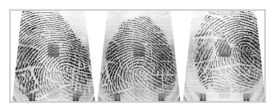

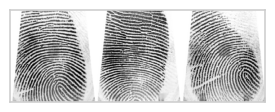

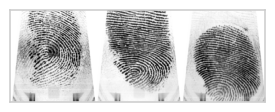

In [5]:
display_dataset('A', size=1.2, users=3)

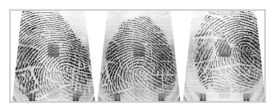

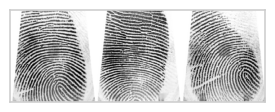

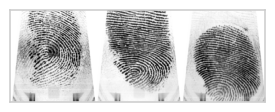

In [6]:
display_dataset('B', size=1.2, users=3)

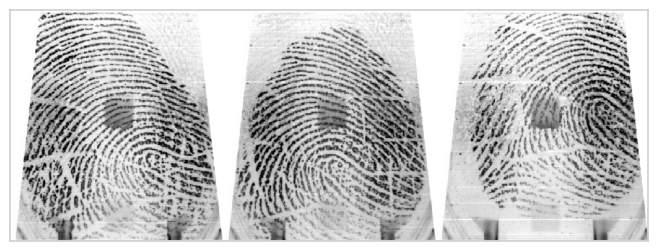

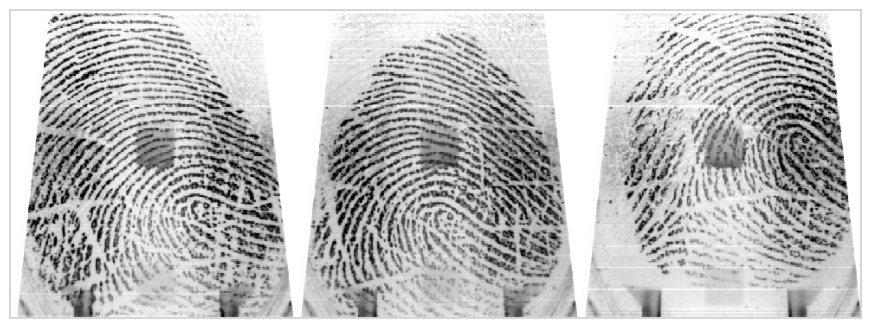

In [7]:
display_dataset('A', size=3, users=1, samples=4)
display_dataset('B', size=4, users=1, samples=4)

# Pre-processing

In [8]:
path = '../Project-Data/train/000_R0_0.bmp'

In [9]:
img = cv2.imread(path, 0)
# DFT computation tends to be faster on arrays with sizes of a power of 2, or a multiple of 2, 3, 5 
# For using an optimal shape, padding might be required (0s)
print(f'Base image shape: {img.shape}')
print(f'Optiml image shape: {(cv2.getOptimalDFTSize(img.shape[0]), cv2.getOptimalDFTSize(img.shape[1]))}')

Base image shape: (356, 328)
Optiml image shape: (360, 360)


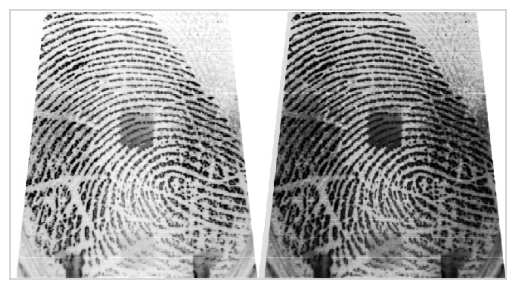

In [10]:
# Before and after equalisation.
# https://en.wikipedia.org/wiki/Histogram_equalization
img_eq = histogram_equalisation(img)
display_image(np.hstack((img, img_eq)))

# img_eq = cv.equalizeHist(img)
# display_image(np.hstack((img, img_eq)))

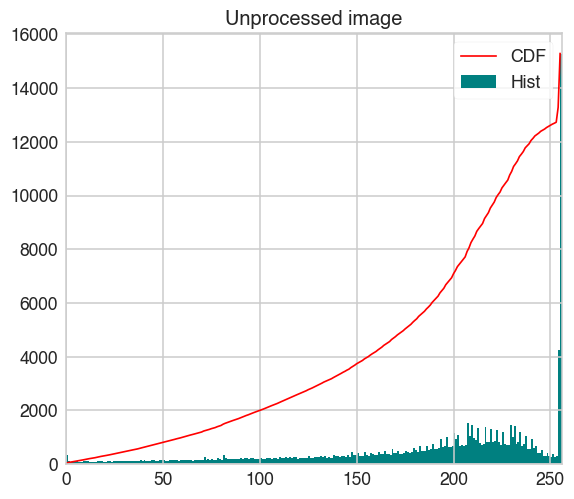

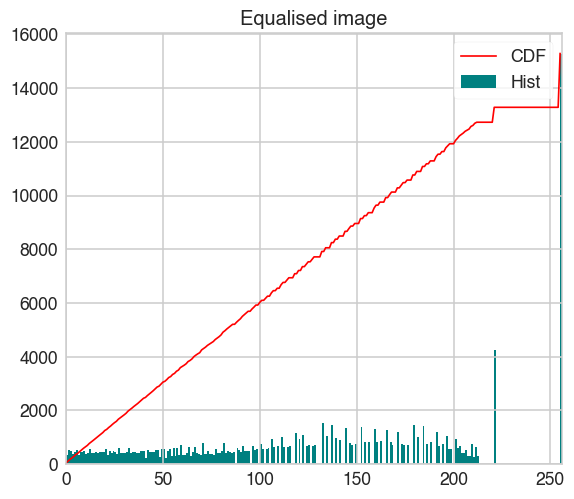

In [11]:
# Equalisation visualisation. 
color_range = 256

plt.plot(cdf_normalised(img, color_range), color = 'red')
plt.hist(img.flatten(), color_range, [0, color_range], color = 'teal')
plt.xlim([0, color_range])
plt.legend(('CDF','Hist'))
plt.title('Unprocessed image')
plt.show()

plt.plot(cdf_normalised(img_eq, color_range), color = 'red')
plt.hist(img_eq.flatten(), color_range, [0, color_range], color = 'teal')
plt.xlim([0, color_range])
plt.legend(('CDF','Hist'))
plt.title('Equalised image')
plt.show()

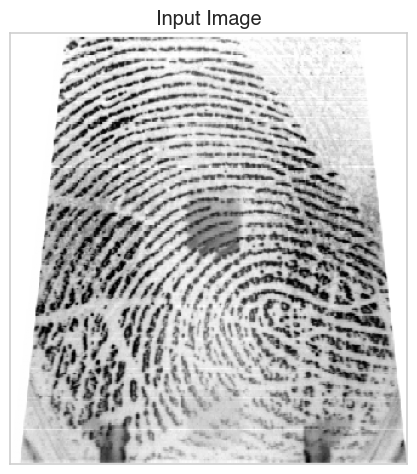

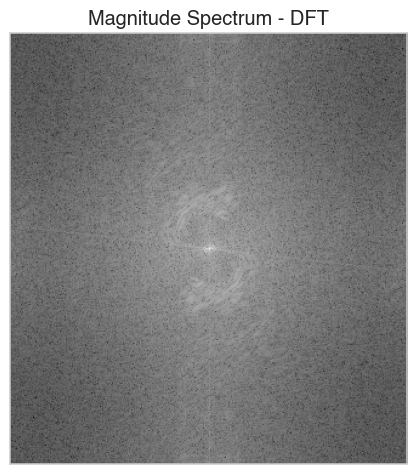

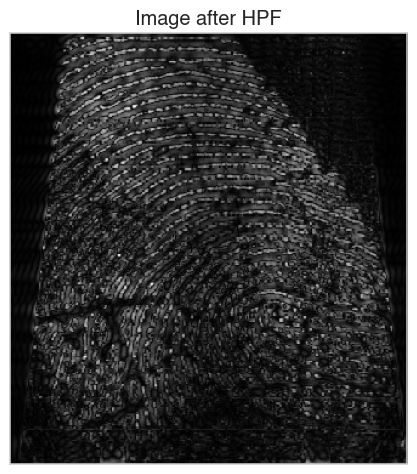

In [12]:
magnitude_spectrum = 20 * np.log(np.abs(fourier_transform(img)))
img_hpf = high_pass_filter(img)

display_image(img, 'Input Image')
display_image(magnitude_spectrum, 'Magnitude Spectrum - DFT')
display_image(img_hpf, 'Image after HPF')

# Feature extraction
We extract the fingerprint ridges by removing the background and thinning the ridges. We also extract ridge endings and bifurcations (minutiae).

In [13]:
from scipy import ndimage, signal

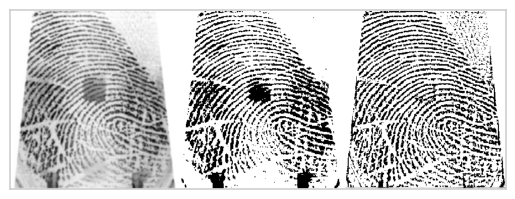

Threshold OTSU: 156.0


In [14]:
# Binarise image
# Direct application tends to obfuscate ridges. The details are much better handled by a 
# rolling window approach as presented in 'binarise' function.
img_bin = binarise(img)
img_blur = cv2.GaussianBlur(img, (5,5), 0)
threshold, img_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

display_image(np.hstack((img_blur, img_otsu, img_bin)))
print(f'Threshold OTSU: {threshold}')

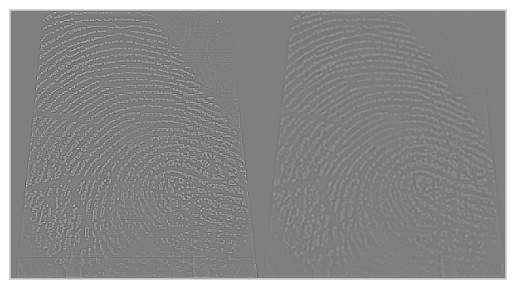

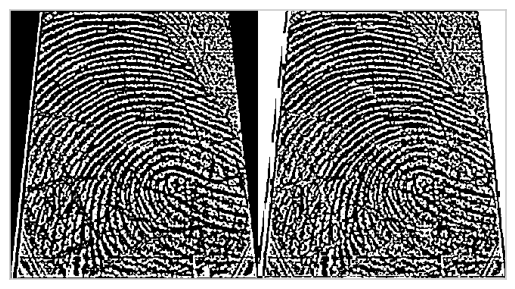

In [15]:
# Edge detection
img_laplace = cv2.Laplacian(img, cv2.CV_64F)
img_blur = cv2.GaussianBlur(img_laplace, (5,5), 0)
ret, img_bin = cv2.threshold(img_blur, 0, 255, 0)
img_bin_custom = binarise(img_blur)
    
display_image(np.hstack((img_laplace, img_blur)))
display_image(np.hstack((img_bin, img_bin_custom)))

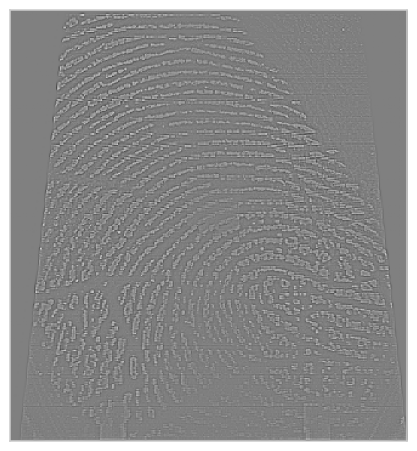

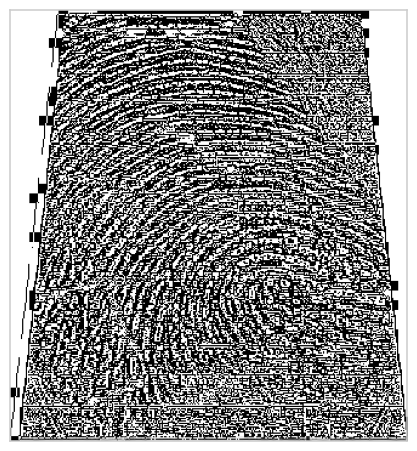

In [16]:
_, bin_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_bin_custom = binarise(img_laplace)

display_image(img_laplace)
display_image(img_bin_custom)

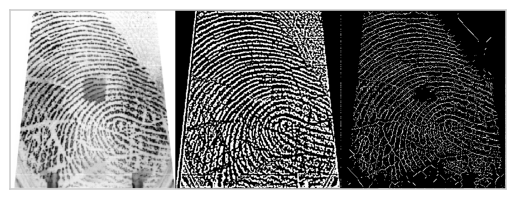

In [17]:
size = np.size(img)
skel = np.zeros(img.shape, np.uint8)

ret, img_base = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
done = False

while not done:
    eroded = cv2.erode(img_base, element)
    temp = cv2.dilate(eroded, element)
    temp = cv2.subtract(img_base, temp)
    skel = cv2.bitwise_or(skel, temp)
    img_base = eroded.copy()

    zeros = size - cv2.countNonZero(img_base)
    if zeros == size:
        done = True
        
# Smoothing required after binarisation. 
display_image(np.hstack((img, img_bin, skel)))

前两个文件（按数字顺序排序）:
1. 000_R0_0.bmp
   完整路径: ../Project-Data/train/000_R0_0.bmp
2. 000_R0_1.bmp
   完整路径: ../Project-Data/train/000_R0_1.bmp


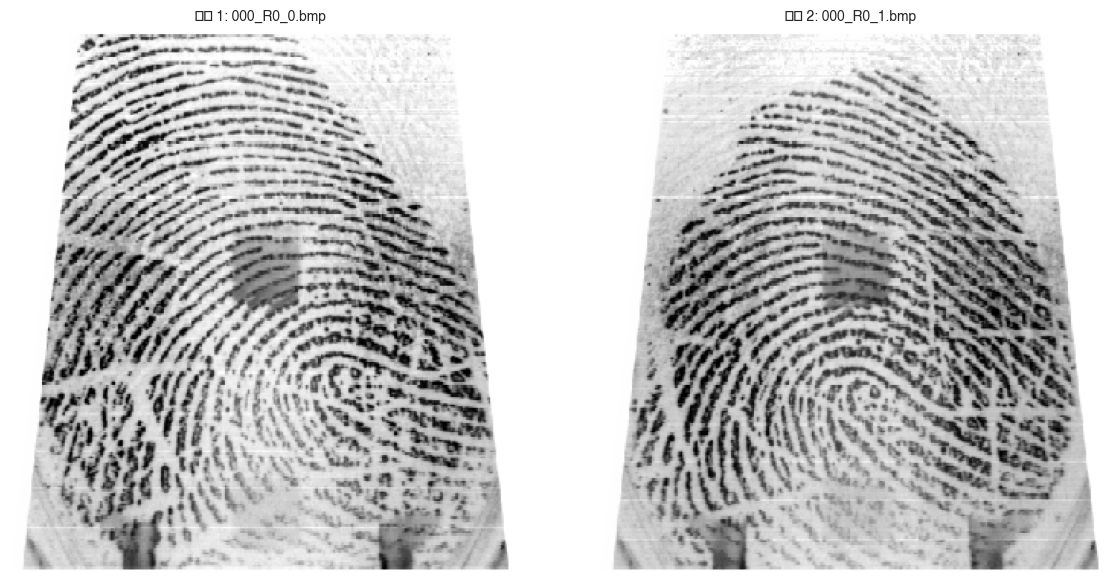


总文件数: 1464


['../Project-Data/train/000_R0_0.bmp', '../Project-Data/train/000_R0_1.bmp']

In [18]:
path_root = f'../Project-Data/train'
all_files = [f'{path_root}/{name}' for name in os.listdir(path_root) if name.endswith('.bmp')]

# 对文件列表进行数字排序（按文件名开头的数字部分排序）
# 文件名格式: 000_R0_0.bmp, 001_R0_1.bmp, etc.
def extract_number(filename):
    """从文件名中提取开头的数字部分用于排序"""
    basename = os.path.basename(filename)
    # 提取文件名开头的数字部分（例如 "000" from "000_R0_0.bmp"）
    parts = basename.split('_')
    if parts:
        try:
            return int(parts[0])
        except ValueError:
            return 0
    return 0

# 按数字顺序排序
all_files = sorted(all_files, key=extract_number)

print("前两个文件（按数字顺序排序）:")
for i, file_path in enumerate(all_files[:2]):
    print(f"{i+1}. {os.path.basename(file_path)}")
    print(f"   完整路径: {file_path}")

# 显示前两个文件对应的图像
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, file_path in enumerate(all_files[:2]):
    img = load_image(file_path, True)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'文件 {i+1}: {os.path.basename(file_path)}', fontsize=10)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print(f"\n总文件数: {len(all_files)}")
all_files[:2]

加载文件: ../Project-Data/train/000_R0_0.bmp
文件名: 000_R0_0.bmp
图像形状: (356, 328)
像素值范围: [0, 255]


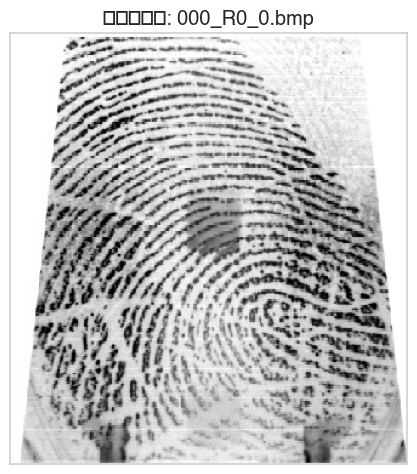

In [19]:
# 加载并显示第一个文件对应的图像
print(f"加载文件: {all_files[0]}")
print(f"文件名: {os.path.basename(all_files[0])}")
raw_img = load_image(all_files[0], True)
print(f"图像形状: {raw_img.shape}")
print(f"像素值范围: [{raw_img.min()}, {raw_img.max()}]")
display_image(raw_img, title=f'第一个文件: {os.path.basename(all_files[0])}')

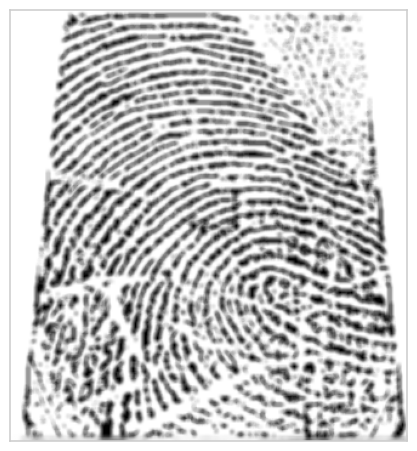

In [20]:
# Gabor filtering (binarise) - edge detection
def build_filters():
    filters = []
    ksize = 5
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), theta=theta, sigma=2.0, 
                                 lambd=15.0, gamma=0.25, psi=0, ktype=cv2.CV_64F)
        # ksize – Size of the filter returned.
        # sigma – Standard deviation of the gaussian envelope.
        # theta – Orientation of the normal to the parallel stripes of a Gabor function.
        # lambd – Wavelength of the sinusoidal factor.
        # gamma – Spatial aspect ratio.
        # psi – Phase offset.
        # ktype – Type of filter coefficients. It can be CV_32F or CV_64F .
        kern /= 1.1 * kern.sum()
        filters.append(kern)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    
    return accum

img_gb = process(binarise(raw_img), build_filters())
# threshold, img_gb = cv.threshold(img_gb, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

display_image(img_gb)

In [21]:
def blur(image, size=(5,5), std=0):
    # Standard cv2 parameters, simplified function
    return cv2.GaussianBlur(image, size, std)

def filter_averaging(image):
    kernel = np.ones((5,5), np.float32) / 25
    return cv2.filter2D(image, -1, kernel)

def filter_bilateral(image):
    return cv2.bilateralFilter(image, 9, 75, 75)

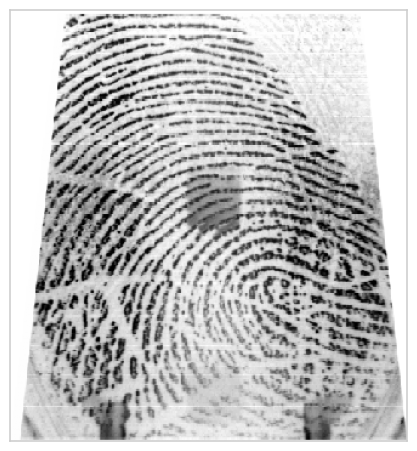

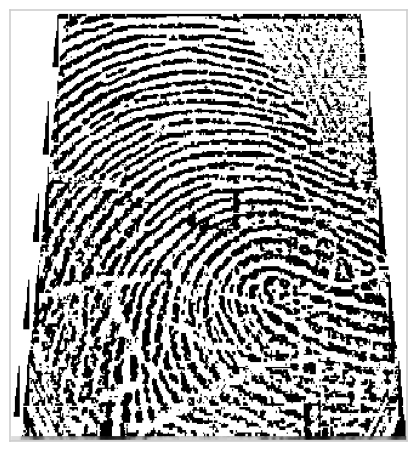

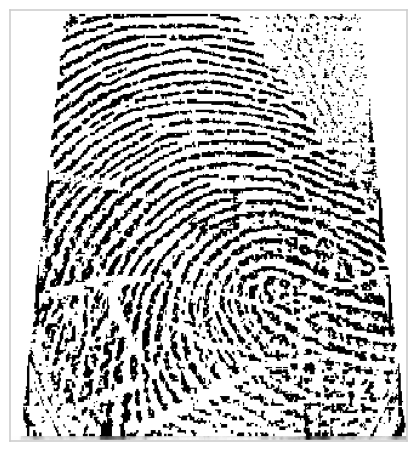

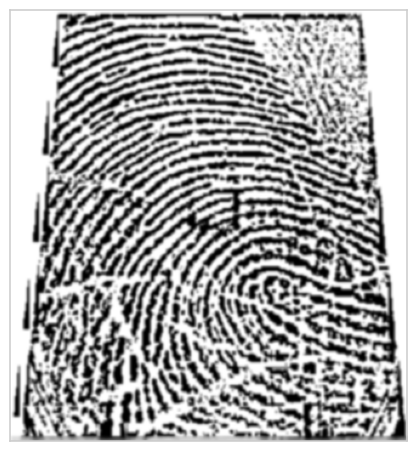

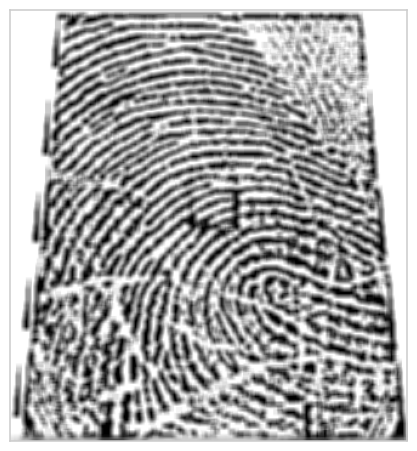

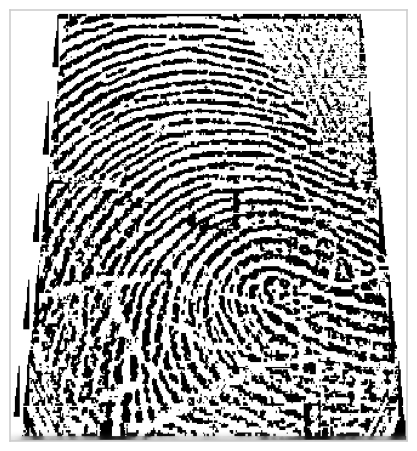

In [ ]:
# from medpy.filter.smoothing import anisotropic_diffusion

raw_img_he = histogram_equalisation(raw_img)
raw_img_he_bin = binarise(raw_img_he)
# raw_img_ad = anisotropic_diffusion(raw_img_he_bin)

display_image(raw_img)
display_image(raw_img_he_bin)

display_image(binarise(raw_img))
display_image(blur(raw_img_he_bin))
display_image(filter_averaging(raw_img_he_bin))
display_image(filter_bilateral(raw_img_he_bin))

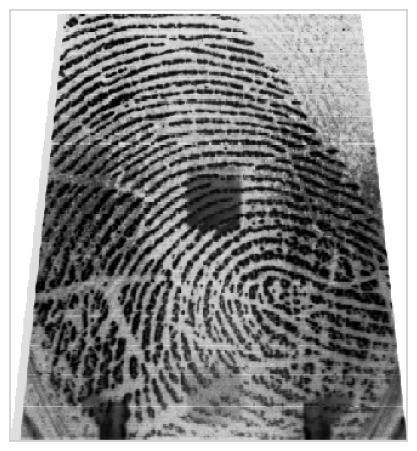

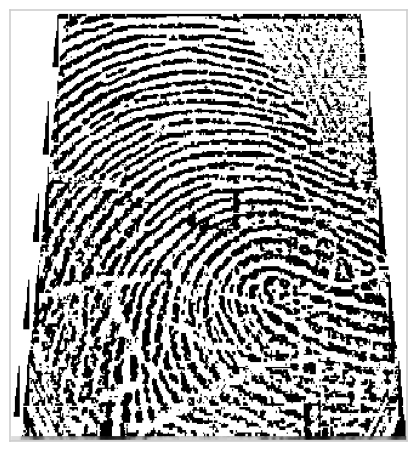

In [26]:
display_image(raw_img_he)
raw_img_he_bin = binarise(raw_img_he)
display_image(raw_img_he_bin)


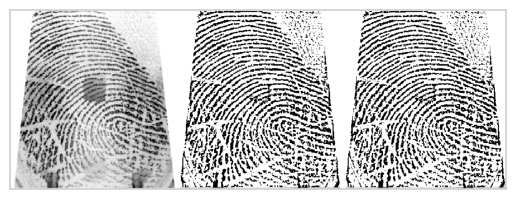

In [23]:
from skimage import exposure

img_bin = binarise(raw_img)
img_adapteq = exposure.equalize_adapthist(img_bin, clip_limit=0.03)
display_image(np.hstack((raw_img, img_bin, img_adapteq * 255)))



# Image Enhancement

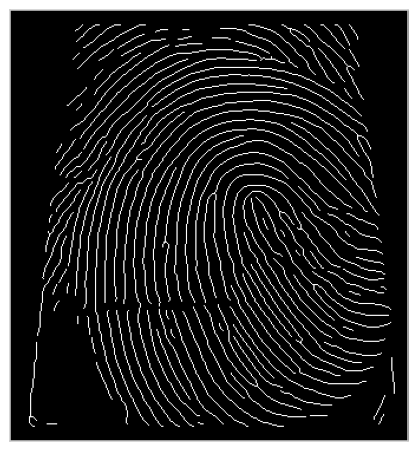

In [30]:
# Revert gray colour levels. Match scale with the raw image for comparison.
path_train = '../Project-Data/train/009_R0_0.bmp'
path_test = '../Project-Data/test/009_R0_4.bmp'

# Image loading
img_train = load_image(path_train, True)
img_test = load_image(path_test, True)
# img = histogram_equalisation(img)

img_enhanced_train = enhance_image(img_train, padding=5)
img_enhanced_test = enhance_image(img_test, padding=5)

display_image(img_enhanced_train)

Loading first training image: 000_R0_0.bmp
Successfully loaded image from: ../Project-Data/train/000_R0_0.bmp
Step-by-Step Visualization of enhance_image Processing
Original image shape: (356, 328)
Original image dtype: uint8
Original image value range: [0, 255]

Step 1: Applying CLAHE (Contrast Limited Adaptive Histogram Equalization)
  Shape: (356, 328), Range: [0, 255]

Step 2: Applying Padding (padding=5)
  Shape: (366, 338) (added 5 pixels on each side)

Step 3: Ridge Segmentation (Normalization + Mask)
  Normalized image shape: (366, 338), Range: [-2.36, 1.24]
  Mask shape: (366, 338), Valid pixels: 108860/123708 (88.0%)

Step 4: Ridge Orientation Estimation
  Orientation image shape: (366, 338)
  Orientation range: [0.00, 3.14] radians
  Orientation range: [0.0°, 180.0°]

Step 5: Ridge Frequency Estimation
  Frequency image shape: (366, 338)
  Frequency range: [0.00, 0.20]
  Median frequency: 0.1579

Step 6: Applying Gabor Filter
  Filtered image shape: (366, 338)
  Filtered ima

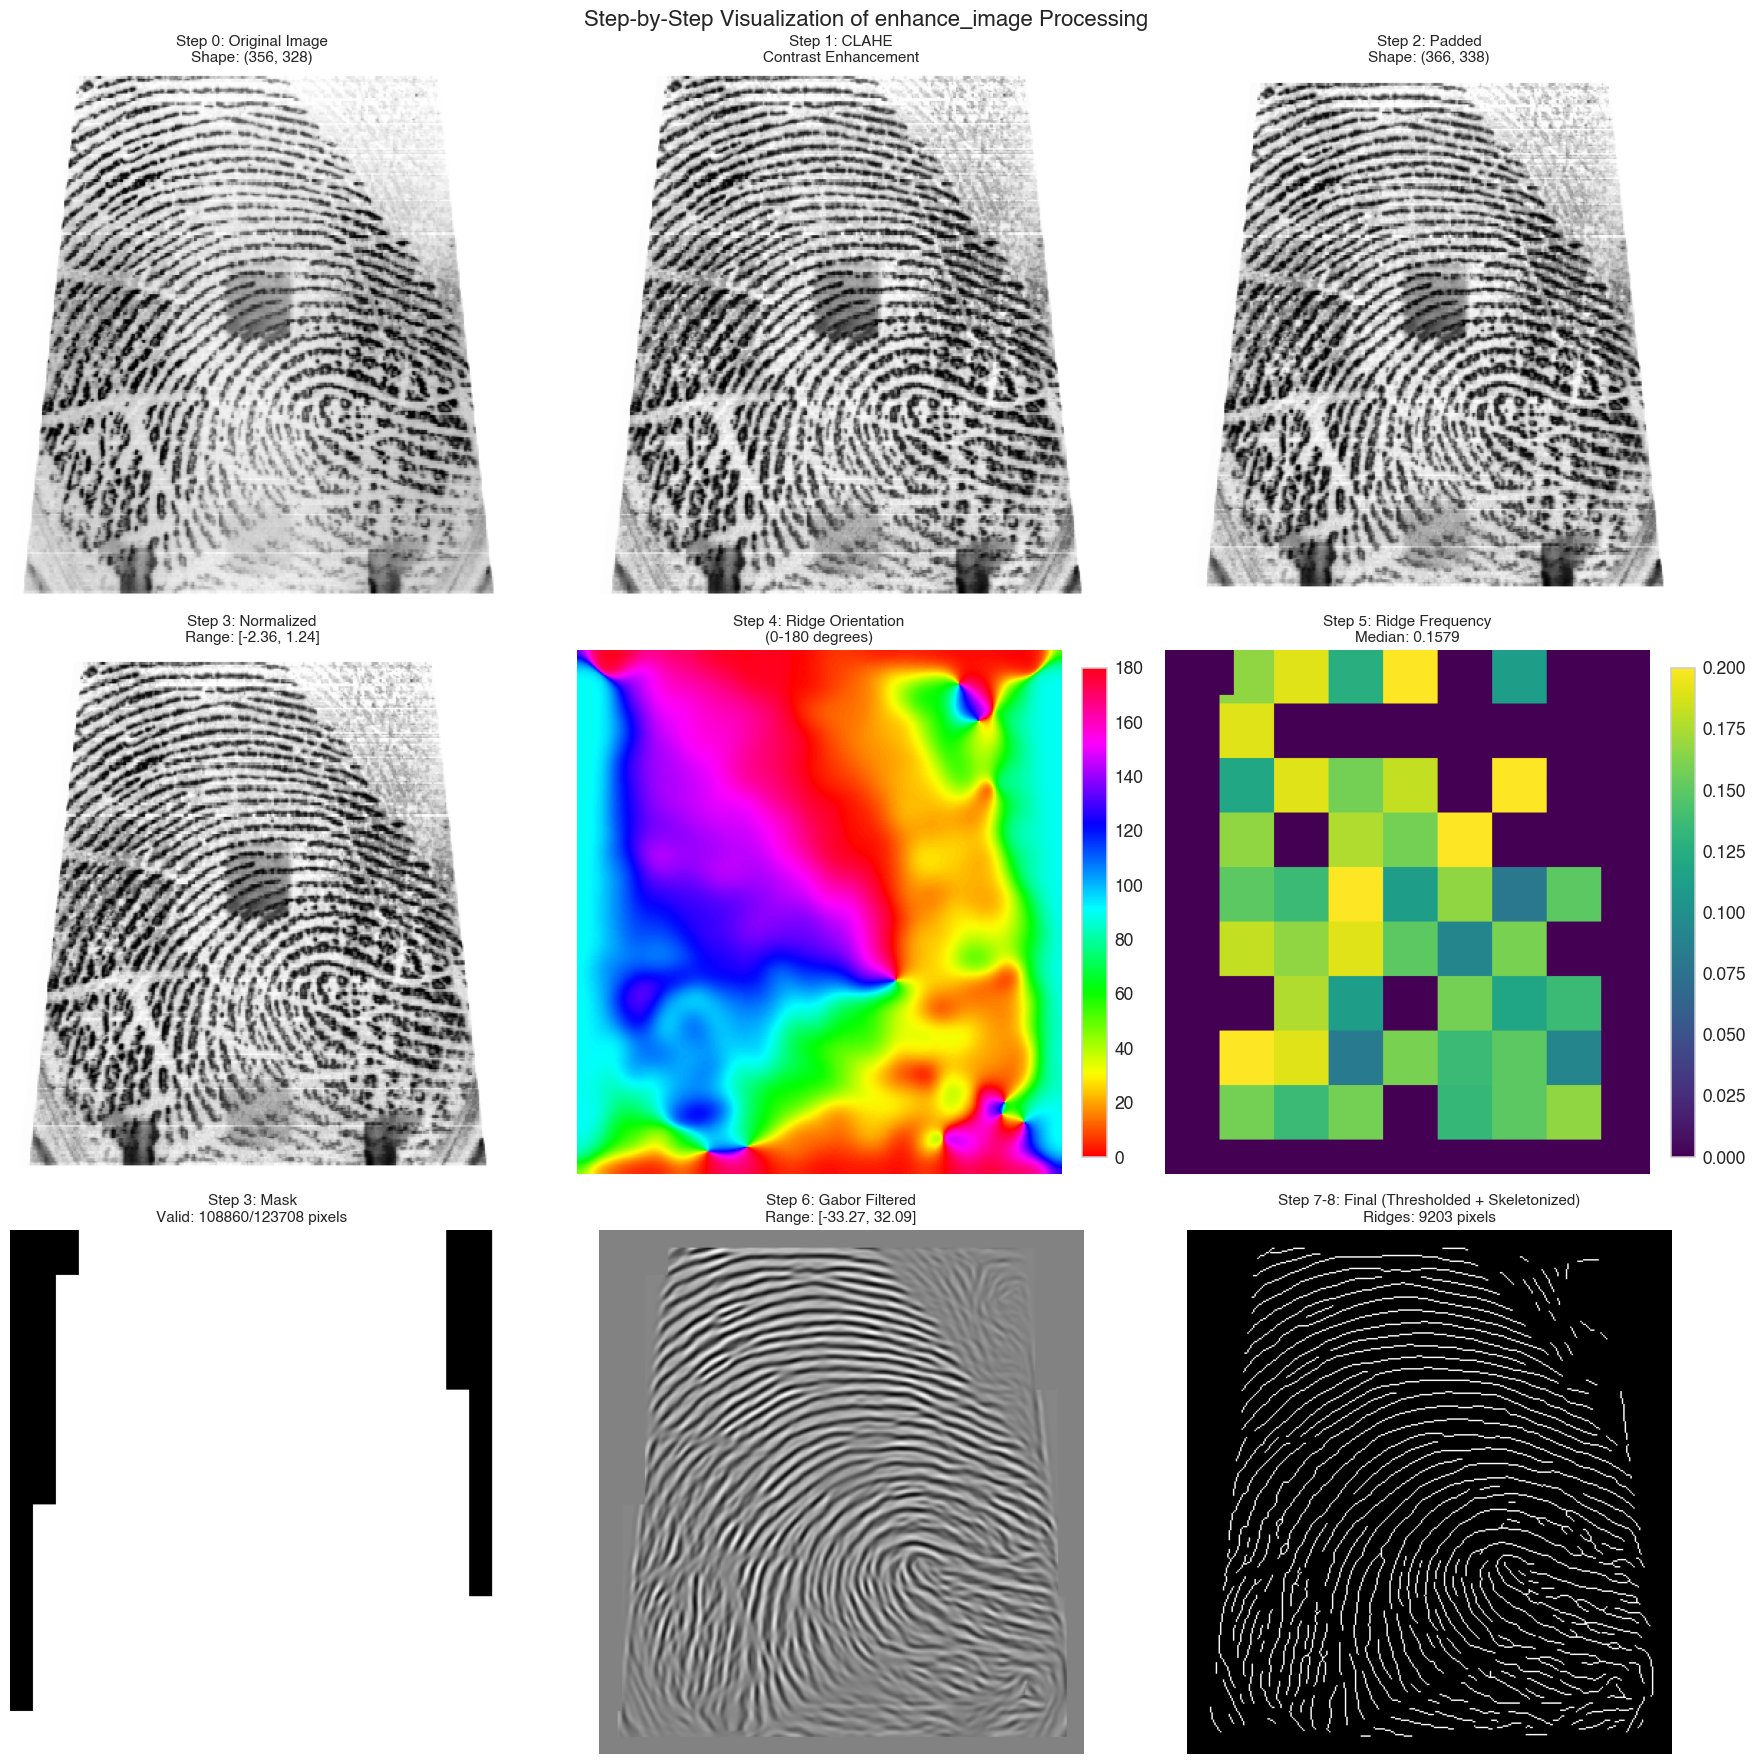

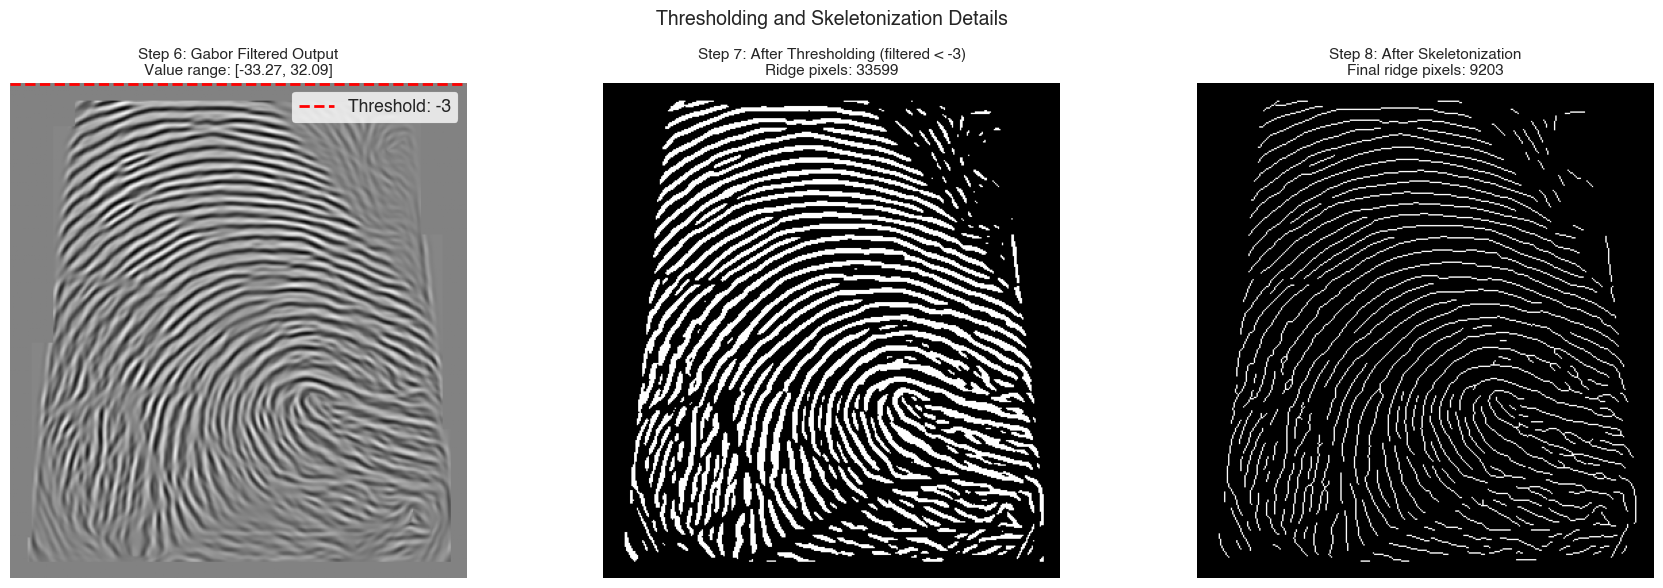


Visualization Complete!


In [30]:
# ============================================
# Visualize enhance_image Step-by-Step Processing
# ============================================
# Step-by-step visualization of enhance_image function to see what each step does

import numpy as np
import matplotlib.pyplot as plt
import cv2
from libs.enhancing import apply_clahe, ridge_segment, ridge_orient, ridge_frequency, ridge_filter
from libs.processing import thin_image, clean_points

# Load the first image from training set
import os
import glob
from libs.basics import load_image

train_dir = '../Project-Data/train'
train_files = sorted(glob.glob(os.path.join(train_dir, '*.bmp')))

if len(train_files) > 0:
    first_train_file = train_files[0]
    print(f"Loading first training image: {os.path.basename(first_train_file)}")
    original_image = load_image(first_train_file, True)
    print(f"Successfully loaded image from: {first_train_file}")
else:
    raise FileNotFoundError("No training images found in ../Project-Data/train/")

print("="*70)
print("Step-by-Step Visualization of enhance_image Processing")
print("="*70)
print(f"Original image shape: {original_image.shape}")
print(f"Original image dtype: {original_image.dtype}")
print(f"Original image value range: [{original_image.min()}, {original_image.max()}]")
print("="*70)

# Step 1: CLAHE (Contrast Limited Adaptive Histogram Equalization)
print("\nStep 1: Applying CLAHE (Contrast Limited Adaptive Histogram Equalization)")
img_clahe = apply_clahe(original_image)
print(f"  Shape: {img_clahe.shape}, Range: [{img_clahe.min()}, {img_clahe.max()}]")

# Step 2: Padding
print("\nStep 2: Applying Padding (padding=5)")
padding = 5
if padding is not None:
    top, bottom, left, right = [padding] * 4
    img_padded = cv2.copyMakeBorder(img_clahe, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)
    print(f"  Shape: {img_padded.shape} (added {padding} pixels on each side)")
else:
    img_padded = img_clahe.copy()
    print("  No padding applied")

# Step 3: Ridge Segmentation (Normalization + Mask)
print("\nStep 3: Ridge Segmentation (Normalization + Mask)")
block_orientation = 16
threshold = 0.1
img_normalised, mask = ridge_segment(img_padded, block_orientation, threshold)
print(f"  Normalized image shape: {img_normalised.shape}, Range: [{img_normalised.min():.2f}, {img_normalised.max():.2f}]")
print(f"  Mask shape: {mask.shape}, Valid pixels: {mask.sum()}/{mask.size} ({100*mask.sum()/mask.size:.1f}%)")

# Step 4: Ridge Orientation
print("\nStep 4: Ridge Orientation Estimation")
sigma_gradient = 1
sigma_block = 7
sigma_orientation = 7
img_orientation = ridge_orient(img_normalised, sigma_gradient, sigma_block, sigma_orientation)
print(f"  Orientation image shape: {img_orientation.shape}")
print(f"  Orientation range: [{img_orientation.min():.2f}, {img_orientation.max():.2f}] radians")
print(f"  Orientation range: [{np.rad2deg(img_orientation.min()):.1f}°, {np.rad2deg(img_orientation.max()):.1f}°]")

# Step 5: Ridge Frequency
print("\nStep 5: Ridge Frequency Estimation")
block_frequency = 38
window_size = 5
min_wave_length = 5
max_wave_length = 15
img_frequency, med = ridge_frequency(img_normalised, mask, img_orientation, block_frequency, window_size,
                                     min_wave_length, max_wave_length)
print(f"  Frequency image shape: {img_frequency.shape}")
print(f"  Frequency range: [{img_frequency.min():.2f}, {img_frequency.max():.2f}]")
print(f"  Median frequency: {med:.4f}")

# Step 6: Gabor Filter
print("\nStep 6: Applying Gabor Filter")
kx = 0.65
ky = 0.65
image_filtered = ridge_filter(img_normalised, img_orientation, med * mask, kx, ky)
print(f"  Filtered image shape: {image_filtered.shape}")
print(f"  Filtered image range: [{image_filtered.min():.2f}, {image_filtered.max():.2f}]")

# Step 7: Thresholding
print("\nStep 7: Thresholding (image_filtered < -3)")
image_thresholded = (image_filtered < -3)
print(f"  Thresholded image shape: {image_thresholded.shape}")
print(f"  Thresholded image dtype: {image_thresholded.dtype}")
print(f"  Ridge pixels (True): {image_thresholded.sum()}/{image_thresholded.size} ({100*image_thresholded.sum()/image_thresholded.size:.1f}%)")

# Step 8: Skeletonization (if enabled)
print("\nStep 8: Skeletonization")
skeletonise = True
if skeletonise:
    image_skeleton = thin_image(image_thresholded)
    image_cleaned = clean_points(image_skeleton)
    print(f"  Skeletonized image shape: {image_cleaned.shape}")
    print(f"  Final ridge pixels: {image_cleaned.sum()}/{image_cleaned.size} ({100*image_cleaned.sum()/image_cleaned.size:.1f}%)")
else:
    image_cleaned = image_thresholded
    print("  Skeletonization skipped")

# Final output
image_final = image_cleaned.astype('uint8')
print(f"\nFinal output shape: {image_final.shape}, dtype: {image_final.dtype}")
print("="*70)

# Visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('Step-by-Step Visualization of enhance_image Processing', fontsize=16, fontweight='bold')

# Row 1: Original, CLAHE, Padded
axes[0, 0].imshow(original_image, cmap='gray')
axes[0, 0].set_title(f'Step 0: Original Image\nShape: {original_image.shape}', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_clahe, cmap='gray')
axes[0, 1].set_title(f'Step 1: CLAHE\nContrast Enhancement', fontsize=11, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(img_padded, cmap='gray')
axes[0, 2].set_title(f'Step 2: Padded\nShape: {img_padded.shape}', fontsize=11, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Normalized, Orientation, Frequency
axes[1, 0].imshow(img_normalised, cmap='gray')
axes[1, 0].set_title(f'Step 3: Normalized\nRange: [{img_normalised.min():.2f}, {img_normalised.max():.2f}]', fontsize=11, fontweight='bold')
axes[1, 0].axis('off')

# Orientation visualization (convert to degrees and show as colormap)
orientation_deg = np.rad2deg(img_orientation) % 180
im1 = axes[1, 1].imshow(orientation_deg, cmap='hsv', vmin=0, vmax=180)
axes[1, 1].set_title(f'Step 4: Ridge Orientation\n(0-180 degrees)', fontsize=11, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im1, ax=axes[1, 1], fraction=0.046, pad=0.04)

# Frequency visualization
im2 = axes[1, 2].imshow(img_frequency, cmap='viridis')
axes[1, 2].set_title(f'Step 5: Ridge Frequency\nMedian: {med:.4f}', fontsize=11, fontweight='bold')
axes[1, 2].axis('off')
plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)

# Row 3: Mask, Filtered, Final
axes[2, 0].imshow(mask, cmap='gray')
axes[2, 0].set_title(f'Step 3: Mask\nValid: {mask.sum()}/{mask.size} pixels', fontsize=11, fontweight='bold')
axes[2, 0].axis('off')

axes[2, 1].imshow(image_filtered, cmap='gray')
axes[2, 1].set_title(f'Step 6: Gabor Filtered\nRange: [{image_filtered.min():.2f}, {image_filtered.max():.2f}]', fontsize=11, fontweight='bold')
axes[2, 1].axis('off')

axes[2, 2].imshow(image_final, cmap='gray')
axes[2, 2].set_title(f'Step 7-8: Final (Thresholded + Skeletonized)\nRidges: {image_final.sum()} pixels', fontsize=11, fontweight='bold')
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()

# Additional detailed visualization for thresholding step
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle('Thresholding and Skeletonization Details', fontsize=14, fontweight='bold')

axes2[0].imshow(image_filtered, cmap='gray')
axes2[0].set_title(f'Step 6: Gabor Filtered Output\nValue range: [{image_filtered.min():.2f}, {image_filtered.max():.2f}]', fontsize=11)
axes2[0].axis('off')
axes2[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Threshold: -3')
axes2[0].legend()

axes2[1].imshow(image_thresholded, cmap='gray')
axes2[1].set_title(f'Step 7: After Thresholding (filtered < -3)\nRidge pixels: {image_thresholded.sum()}', fontsize=11)
axes2[1].axis('off')

axes2[2].imshow(image_final, cmap='gray')
axes2[2].set_title(f'Step 8: After Skeletonization\nFinal ridge pixels: {image_final.sum()}', fontsize=11)
axes2[2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Visualization Complete!")
print("="*70)



# Minutiae extraction

In [31]:
# Minutiae libs
from scipy.spatial import distance
from itertools import combinations

from libs.minutiae import *

Base img minutiae: 74 
  - Termination : 70 
  - Bifurcation : 4 
INFO: Plotting terminations' coordinates
INFO: Plotting bifurcations' coordinates


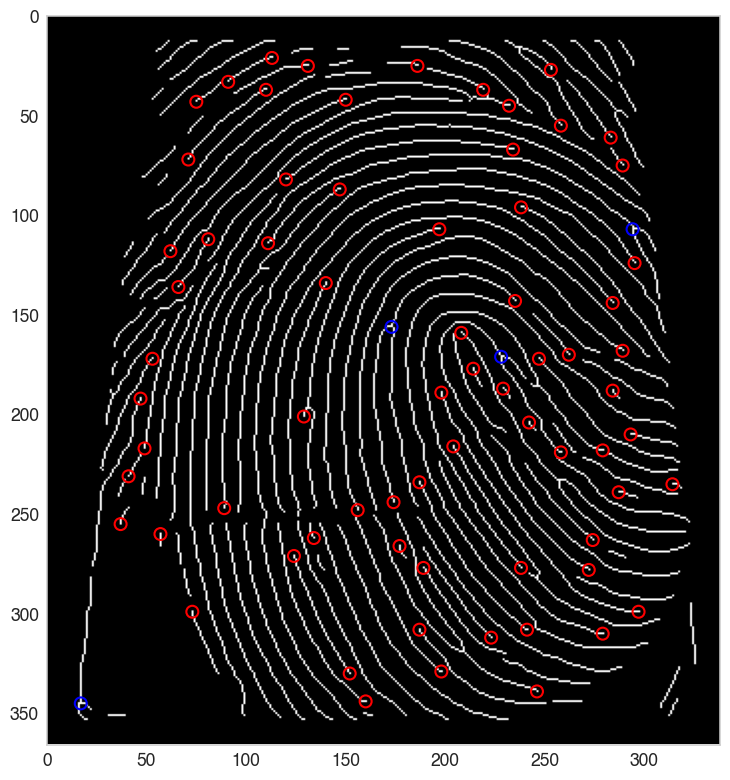

Test img minutiae: 80 
  - Termination : 74 
  - Bifurcation : 6 
INFO: Plotting terminations' coordinates
INFO: Plotting bifurcations' coordinates


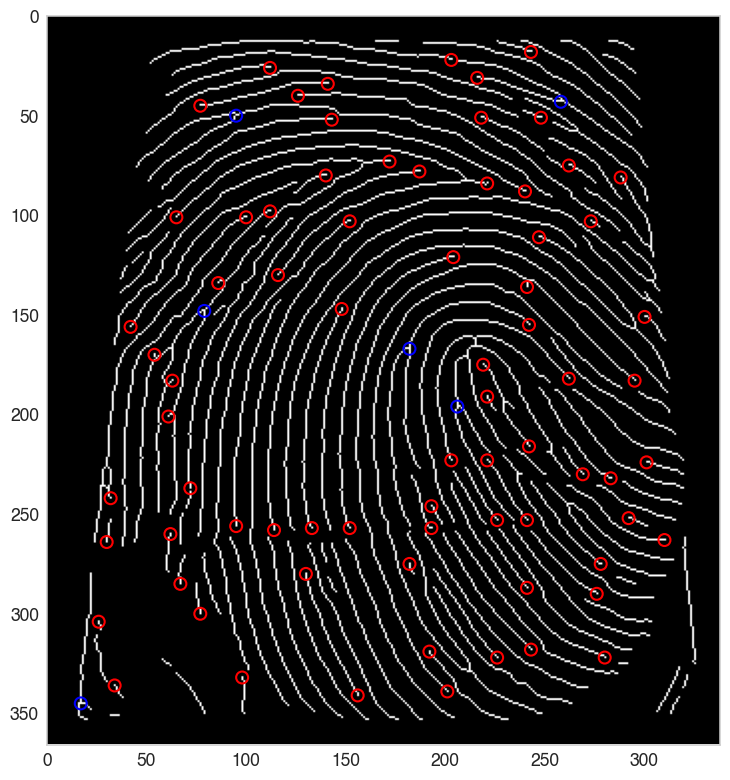

In [32]:

# type: 0=no minutia，1=termination，3=bifurcation

import importlib
import libs.minutiae
importlib.reload(libs.minutiae)
from libs.minutiae import process_minutiae, plot_minutiae


minutiae_base, types_base = process_minutiae(
    img_enhanced_train, 
    min_distance=10,           
    eliminate_false=True,      
    false_min_distance=15,     
    max_neighbors=3,         
    return_types=True          
)

print(f"Base img minutiae: {len(minutiae_base)} ")
print(f"  - Termination : {types_base.count(1)} ")
print(f"  - Bifurcation : {types_base.count(3)} ")

# 按类型分开 minutiae
terminations_base = [m for m, t in zip(minutiae_base, types_base) if t == 1]
bifurcations_base = [m for m, t in zip(minutiae_base, types_base) if t == 3]
plot_minutiae(img_enhanced_train, terminations=terminations_base, bifurcations=bifurcations_base, size=8)


minutiae_test, types_test = process_minutiae(
    img_enhanced_test, 
    min_distance=10,           
    eliminate_false=True,   
    false_min_distance=15,     
    max_neighbors=3,           
    return_types=True        
)
print(f"Test img minutiae: {len(minutiae_test)} ")
print(f"  - Termination : {types_test.count(1)} ")
print(f"  - Bifurcation : {types_test.count(3)} ")


terminations_test = [m for m, t in zip(minutiae_test, types_test) if t == 1]
bifurcations_test = [m for m, t in zip(minutiae_test, types_test) if t == 3]
plot_minutiae(img_enhanced_test, terminations=terminations_test, bifurcations=bifurcations_test, size=8)

Best rotation angle: -2 
in this angle 42 matches
Tuple profile found: 1 matches

 calculating score....
INFO: Score - 1.05
  - Base minutiae : 74
  - Test minutiae: 80
  - Matches count: 42


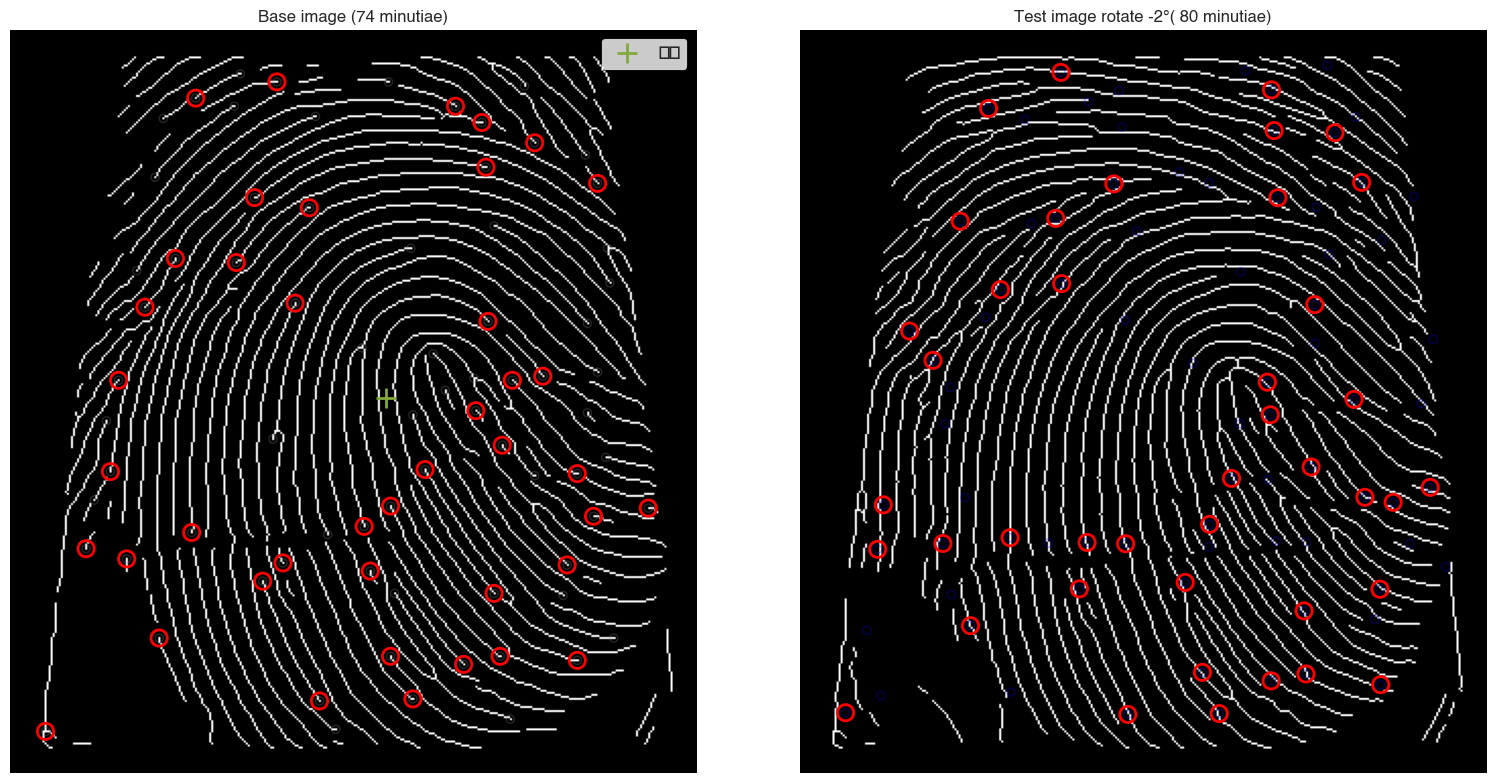


done!


In [33]:

from libs.minutiae import generate_tuple_profile
from libs.matching import match_tuples, evaluate
from libs.basics import euclidian_distance
from libs.enhancing import ridge_orient
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
import math



def compute_centroid(minutiae):
    
    if len(minutiae) == 0:
        return None
    coords = np.array(minutiae)
    centroid = np.mean(coords, axis=0)
    return centroid

def align_by_centroid(minutiae, target_centroid):
    
    if len(minutiae) == 0:
        return minutiae
    current_centroid = compute_centroid(minutiae)
    if current_centroid is None:
        return minutiae
    translation = target_centroid - current_centroid
    aligned = [(y + translation[0], x + translation[1]) for y, x in minutiae]
    return aligned

def rotate_minutiae(minutiae, centroid, angle_deg):
    
    if len(minutiae) == 0 or abs(angle_deg) < 0.1:
        return minutiae
    
    angle_rad = np.deg2rad(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    
    coords = np.array(minutiae) - centroid
    coords_rotated = coords @ rotation_matrix.T
    rotated = [(y + centroid[0], x + centroid[1]) for y, x in coords_rotated]
    return rotated

centroid_base = compute_centroid(minutiae_base)
centroid_test = compute_centroid(minutiae_test)


minutiae_test_aligned = align_by_centroid(minutiae_test, centroid_base)



def extract_minutiae_orientations(image, minutiae):
    
    orientation = ridge_orient(image, sigma_gradient=1, sigma_block=7, sigma_orientation=7)
    
    orientations = []
    for y, x in minutiae:
        
        y_idx = int(np.clip(y, 0, orientation.shape[0] - 1))
        x_idx = int(np.clip(x, 0, orientation.shape[1] - 1))
        angle_rad = orientation[y_idx, x_idx]
        angle_deg = np.rad2deg(angle_rad) % 180  # 方向是0-180度（因为脊线方向是周期性的）
        orientations.append(angle_deg)
    
    return orientations


orientations_base = extract_minutiae_orientations(img_enhanced_train, minutiae_base)
orientations_test = extract_minutiae_orientations(img_enhanced_test, minutiae_test)


# ========== Hough Transform ==========


def find_best_rotation_with_matching(minutiae1, minutiae2, orientations1, orientations2, 
                                     types1, types2,
                                     angle_range=(-10, 10), angle_step=1, 
                                     distance_threshold=20, orientation_threshold=15):

    if len(minutiae1) < 3 or len(minutiae2) < 3:
        return 0, [], []
    
    best_angle = 0
    best_matches_count = 0
    best_common_base = []
    best_common_test = []
    
    centroid1 = compute_centroid(minutiae1)
    centroid2 = compute_centroid(minutiae2)
    
  
    coords1 = np.array(minutiae1) - centroid1
    

    for angle in range(angle_range[0], angle_range[1] + 1, angle_step):
      
        minutiae2_rotated = rotate_minutiae(minutiae2, centroid2, angle)
        coords2_rotated = np.array(minutiae2_rotated) - centroid2
   
        orientations2_rotated = [(o + angle) % 180 for o in orientations2]
        
      
        distances = cdist(coords1, coords2_rotated)
        
       
        matches_base = []
        matches_test = []
        used2 = set()
        
        for i, m1 in enumerate(minutiae1):
            
            min_dist_idx = np.argmin(distances[i])
            min_dist = distances[i][min_dist_idx]
            
            
            ori1 = orientations1[i]
            ori2_rotated = orientations2_rotated[min_dist_idx]
           
            ori_diff = abs(ori1 - ori2_rotated)
            ori_diff = min(ori_diff, 180 - ori_diff) 
            
        
            type1 = types1[i]
            type2 = types2[min_dist_idx]
            type_match = (type1 == type2)
            
       
            if (min_dist < distance_threshold and 
                ori_diff < orientation_threshold and 
                type_match and  
                min_dist_idx not in used2):
                matches_base.append(m1)
                matches_test.append(minutiae2_rotated[min_dist_idx])
                used2.add(min_dist_idx)
        

        if len(matches_base) > best_matches_count:
            best_matches_count = len(matches_base)
            best_angle = angle
            best_common_base = matches_base
            best_common_test = matches_test
    
    return best_angle, best_common_base, best_common_test


best_angle, common_points_base, common_points_test = find_best_rotation_with_matching(
    minutiae_base, 
    minutiae_test_aligned,
    orientations_base,
    orientations_test,
    types_base,
    types_test,
    angle_range=(-30, 30),  # 旋转角度限制在10度以内
    angle_step=1,
    distance_threshold=20,   # 位置距离阈值（像素）
    orientation_threshold=15  # 方向角度阈值（度）
)

print(f"Best rotation angle: {best_angle} ")
print(f"in this angle {len(common_points_base)} matches")

# 验证匹配点的类型
if len(common_points_base) > 0:

    type_matches = 0
    for i, m_base in enumerate(common_points_base):
        # 找到 base 中的索引
        base_idx = minutiae_base.index(m_base) if m_base in minutiae_base else -1
        # 找到 test 中的索引（在旋转后的列表中）
        test_idx = -1
        for j, m_test in enumerate(minutiae_test_aligned):
            if m_test == common_points_test[i]:
                test_idx = j
                break
        
        if base_idx >= 0 and test_idx >= 0:
            type_base = types_base[base_idx]
            type_test = types_test[test_idx]
            match_status = "✓" if type_base == type_test else "✗"
            if type_base == type_test:
                type_matches += 1


if abs(best_angle) > 0.1:
    centroid_test_aligned = compute_centroid(minutiae_test_aligned)
    minutiae_test_final = rotate_minutiae(minutiae_test_aligned, centroid_test_aligned, best_angle)

else:
    minutiae_test_final = minutiae_test_aligned


# ========== tuple profile  ==========

tuple_profile_base = generate_tuple_profile(minutiae_base)
tuple_profile_test_final = generate_tuple_profile(minutiae_test_final)


common_points_base_tuple, common_points_test_tuple = match_tuples(
    tuple_profile_base, 
    tuple_profile_test_final, 
    th_range=0.01,
    th_angle=1.5
)

print(f"Tuple profile found: {len(common_points_base_tuple)} matches")


all_matches_base = {}
all_matches_test = {}

for b, t in zip(common_points_base, common_points_test):
    all_matches_base[b] = t

for b, t in zip(common_points_base_tuple, common_points_test_tuple):
    if b not in all_matches_base:
        all_matches_base[b] = t

common_points_base = list(all_matches_base.keys())
common_points_test = [all_matches_base[b] for b in common_points_base]


# ========== score  ==========
print("\n calculating score....")

total_minutiae = max(len(minutiae_base), len(minutiae_test_final))
min_minutiae = min(len(minutiae_base), len(minutiae_test_final))
matched_count = len(common_points_base)

# 计算匹配分数
minutiae_score_threshold = total_minutiae / 2
match_result = evaluate(common_points_base, minutiae_base, minutiae_test_final)

match_score_ratio = matched_count / minutiae_score_threshold if minutiae_score_threshold > 0 else 0
match_percentage_min = (matched_count / min_minutiae) * 100 if min_minutiae > 0 else 0
match_percentage_total = (matched_count / total_minutiae) * 100 if total_minutiae > 0 else 0


print(f"  - Base minutiae : {len(minutiae_base)}")
print(f"  - Test minutiae: {len(minutiae_test_final)}")
print(f"  - Matches count: {matched_count}")



# ========== visualization ==========

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 显示 base 图像和匹配点
axes[0].imshow(img_enhanced_train, cmap='gray')
axes[0].set_title(f'Base image ({len(minutiae_base)} minutiae)', fontsize=12)
axes[0].axis('off')


# 标记质心
if centroid_base is not None:
    axes[0].plot(centroid_base[1], centroid_base[0], 'g+', markersize=15, markeredgewidth=2, label='质心')
    axes[0].legend()

# 标记所有 minutiae
for y, x in minutiae_base:
    circle = plt.Circle((x, y), radius=2, linewidth=1, color='gray', fill=False, alpha=0.3)
    axes[0].add_patch(circle)

# 标记匹配的点（红色）
for y, x in common_points_base:
    circle = plt.Circle((x, y), radius=4, linewidth=2, color='red', fill=False)
    axes[0].add_patch(circle)

# 显示 test 图像（对齐+旋转后）
axes[1].imshow(img_enhanced_test, cmap='gray')
axes[1].set_title(f'Test image rotate {best_angle}°( {len(minutiae_test_final)} minutiae)', fontsize=12)
axes[1].axis('off')

# 标记对齐后的 minutiae
for y, x in minutiae_test_final:
    circle = plt.Circle((x, y), radius=2, linewidth=1, color='blue', fill=False, alpha=0.3)
    axes[1].add_patch(circle)

# 标记匹配的点（红色）
for y, x in common_points_test:
    circle = plt.Circle((x, y), radius=4, linewidth=2, color='red', fill=False)
    axes[1].add_patch(circle)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("done!")
print("=" * 60)


In [ ]:

import os
import numpy as np
from libs.basics import load_image
from libs.enhancing import enhance_image, ridge_orient
from libs.minutiae import process_minutiae

features_dir = '../features'
os.makedirs(features_dir, exist_ok=True)


def extract_minutiae_orientations(image, minutiae):
 
    orientation = ridge_orient(image, sigma_gradient=1, sigma_block=7, sigma_orientation=7)
    orientations = []
    for y, x in minutiae:
        y_idx = int(np.clip(y, 0, orientation.shape[0] - 1))
        x_idx = int(np.clip(x, 0, orientation.shape[1] - 1))
        angle_rad = orientation[y_idx, x_idx]
        angle_deg = np.rad2deg(angle_rad) % 180  # 0-180度
        orientations.append(angle_deg)
    return orientations

# Enroll 训练集（0-10 用户）
train_path = '../Project-Data/train'
enrolled_users = []

for user_id in range(11):  # 0-10
    print(f"processing user {user_id:03d}...")
    
    user_features = []  
    
    for sample_id in range(3): 
        train_file = f'{train_path}/{user_id:03d}_R0_{sample_id}.bmp'
        
        if os.path.exists(train_file):
            # 加载和增强图像
            img = load_image(train_file, True)
            if img is not None:
                img_enhanced = enhance_image(img, padding=5)
                
                # 提取 minutiae 和类型
                minutiae, types = process_minutiae(img_enhanced, return_types=True, 
                                                   eliminate_false=True, 
                                                   false_min_distance=15, 
                                                   max_neighbors=3)
                
                if len(minutiae) > 0:
                  
                    orientations = extract_minutiae_orientations(img_enhanced, minutiae)
                    
             
                    features = []
                    for i, (y, x) in enumerate(minutiae):
                        features.append([x, y, orientations[i], types[i]])
                    
                    feature_array = np.array(features, dtype=np.float32)
                    user_features.append(feature_array)
                    
                    print(f"  sample {sample_id}: {len(minutiae)} minutiae")
                else:
                    print(f"  sample {sample_id}: no minutiae")
            else:
                print(f"  sample {sample_id}: no imgae")
        else:
            print(f"  sample {sample_id}: no file")
    
    if len(user_features) > 0:

        user_features_array = np.array(user_features, dtype=object)
        save_path = f'{features_dir}/user_{user_id:03d}_features.npy'
        np.save(save_path, user_features_array, allow_pickle=True)
        enrolled_users.append(user_id)
        
        # 显示保存的信息
        total_minutiae = sum(len(f) for f in user_features)
        print(f"  ✓ saved in: {save_path}")
        print(f"  ✓ {len(user_features)} samples,  {total_minutiae}  minutiae")
    else:
        print(f"  ✗ user {user_id:03d} has no features")

print(f"\n{'='*80}")
print(f"Enrollment finished！")
print(f"  - enrolled_users: {len(enrolled_users)}")

print("=" * 80)

processing user 000...
  sample 0: 85 minutiae
  sample 1: 100 minutiae
  sample 2: 99 minutiae
  ✓ saved in: ../features/user_000_features.npy
  ✓ 3 samples,  284  minutiae
processing user 001...
  sample 0: 42 minutiae
  sample 1: 47 minutiae
  sample 2: 62 minutiae
  ✓ saved in: ../features/user_001_features.npy
  ✓ 3 samples,  151  minutiae
processing user 002...
  sample 0: 85 minutiae
  sample 1: 56 minutiae
  sample 2: 75 minutiae
  ✓ saved in: ../features/user_002_features.npy
  ✓ 3 samples,  216  minutiae
processing user 003...
  sample 0: 92 minutiae
  sample 1: 85 minutiae
  sample 2: 98 minutiae
  ✓ saved in: ../features/user_003_features.npy
  ✓ 3 samples,  275  minutiae
processing user 004...
  sample 0: 51 minutiae
  sample 1: 38 minutiae
  sample 2: 39 minutiae
  ✓ saved in: ../features/user_004_features.npy
  ✓ 3 samples,  128  minutiae
processing user 005...
  sample 0: 47 minutiae
  sample 1: 79 minutiae
  sample 2: 54 minutiae
  ✓ saved in: ../features/user_005_feat

In [ ]:

import os
import numpy as np
from libs.basics import load_image
from libs.enhancing import enhance_image, ridge_orient
from libs.minutiae import process_minutiae
from scipy.spatial.distance import cdist

print("=" * 80)
print("Matching")
print("=" * 80)


features_dir = '../features'
validate_path = '../Project-Data/validate'

def extract_minutiae_orientations(image, minutiae):

    orientation = ridge_orient(image, sigma_gradient=1, sigma_block=7, sigma_orientation=7)
    orientations = []
    for y, x in minutiae:
        y_idx = int(np.clip(y, 0, orientation.shape[0] - 1))
        x_idx = int(np.clip(x, 0, orientation.shape[1] - 1))
        angle_rad = orientation[y_idx, x_idx]
        angle_deg = np.rad2deg(angle_rad) % 180
        orientations.append(angle_deg)
    return orientations

def compute_centroid_from_features(features):

    if len(features) == 0:
        return None
    coords = features[:, :2]  # x, y 坐标
    centroid = np.mean(coords, axis=0)
    return centroid

def align_features_by_centroid(features, target_centroid):

    if len(features) == 0:
        return features
    current_centroid = compute_centroid_from_features(features)
    if current_centroid is None:
        return features
    translation = target_centroid - current_centroid
    aligned_features = features.copy()
    aligned_features[:, 0] += translation[0]  # x
    aligned_features[:, 1] += translation[1]  # y
    return aligned_features

def rotate_features(features, centroid, angle_deg):

    if len(features) == 0 or abs(angle_deg) < 0.1:
        return features
    angle_rad = np.deg2rad(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    
    coords = features[:, :2] - centroid
    coords_rotated = coords @ rotation_matrix.T
    rotated_features = features.copy()
    rotated_features[:, 0] = coords_rotated[:, 0] + centroid[0]
    rotated_features[:, 1] = coords_rotated[:, 1] + centroid[1]
    # 旋转方向
    rotated_features[:, 2] = (rotated_features[:, 2] + angle_deg) % 180
    return rotated_features

def match_features(train_features, validate_features, 
                   angle_range=(-10, 10), angle_step=1,
                   distance_threshold=20, orientation_threshold=15):
   
    if len(train_features) == 0 or len(validate_features) == 0:
        return 0, 0, 0.0
    
    best_angle = 0
    best_matches_count = 0
    
    # 提取位置、方向、类型
    train_pos = train_features[:, :2]  # x, y
    train_ori = train_features[:, 2]  # orientation
    train_type = train_features[:, 3]  # type
    
    validate_pos = validate_features[:, :2]
    validate_ori = validate_features[:, 2]
    validate_type = validate_features[:, 3]
    
    centroid_train = compute_centroid_from_features(train_features)
    centroid_validate = compute_centroid_from_features(validate_features)
    

    validate_aligned = align_features_by_centroid(validate_features, centroid_train)
    validate_pos_aligned = validate_aligned[:, :2]
    validate_ori_aligned = validate_aligned[:, 2]
    
    coords_train = train_pos - centroid_train
    
    for angle in range(angle_range[0], angle_range[1] + 1, angle_step):

        validate_rotated = rotate_features(validate_aligned, centroid_train, angle)
        validate_pos_rotated = validate_rotated[:, :2]
        validate_ori_rotated = validate_rotated[:, 2]
        
        coords_validate = validate_pos_rotated - centroid_train
        

        distances = cdist(coords_train, coords_validate)
        
        matches_count = 0
        used_validate = set()
        
        for i in range(len(train_features)):
            min_dist_idx = np.argmin(distances[i])
            min_dist = distances[i][min_dist_idx]
            
       
            ori_diff = abs(train_ori[i] - validate_ori_rotated[min_dist_idx])
            ori_diff = min(ori_diff, 180 - ori_diff)
            
 
            type_match = (train_type[i] == validate_type[min_dist_idx])
            
 
            if (min_dist < distance_threshold and 
                ori_diff < orientation_threshold and 
                type_match and
                min_dist_idx not in used_validate):
                matches_count += 1
                used_validate.add(min_dist_idx)
        
        if matches_count > best_matches_count:
            best_matches_count = matches_count
            best_angle = angle
    

    total_minutiae = max(len(train_features), len(validate_features))
    match_score = best_matches_count / (total_minutiae / 2) if total_minutiae > 0 else 0.0
    
    return best_angle, best_matches_count, match_score


print("\nloading enrolled features...")
enrolled_features = {}
for user_id in range(11):  # 0-10
    feature_file = f'{features_dir}/user_{user_id:03d}_features.npy'
    if os.path.exists(feature_file):
        features = np.load(feature_file, allow_pickle=True)
        enrolled_features[user_id] = features
       

print(f"\n loaded features from {len(enrolled_features)} users ")


print("\n" + "=" * 80)
print("matcing...")
print("=" * 80)

results = []

for user_id in range(11):  # 0-10
    print(f"\n processing sample from{user_id:03d} ...")
    
    # 加载验证样本
    validate_file = f'{validate_path}/{user_id:03d}_R0_4.bmp'
    if not os.path.exists(validate_file):
        validate_file = f'../Project-Data/test/{user_id:03d}_R0_4.bmp'
    
    if not os.path.exists(validate_file):
        print(f"  ✗ no sample")
        continue
    
    img_validate = load_image(validate_file, True)
    if img_validate is None:
        print(f"  ✗ no image")
        continue
    
    # 提取验证样本的特征
    img_validate_enhanced = enhance_image(img_validate, padding=5)
    minutiae_validate, types_validate = process_minutiae(img_validate_enhanced, return_types=True,
                                                         eliminate_false=True,
                                                         false_min_distance=15,
                                                         max_neighbors=3)
    
    if len(minutiae_validate) == 0:
        print(f"  ✗ no minutiae")
        continue
    
    orientations_validate = extract_minutiae_orientations(img_validate_enhanced, minutiae_validate)
    
    # 构建验证特征数组 [x, y, orientation, type]
    validate_features = []
    for i, (y, x) in enumerate(minutiae_validate):
        validate_features.append([x, y, orientations_validate[i], types_validate[i]])
    validate_features = np.array(validate_features, dtype=np.float32)
    
    print(f"  test sample: {len(validate_features)} minutiae")
    
    # 与所有已注册用户进行匹配
    best_match_user = -1
    best_match_score = 0.0
    best_match_angle = 0
    best_match_count = 0
    all_scores = []
    
    for enrolled_user_id, train_features_list in enrolled_features.items():
        # 对每个训练样本进行匹配，取最高分
        user_best_score = 0.0
        user_best_angle = 0
        user_best_count = 0
        
        for train_features in train_features_list:
            angle, matched_count, score = match_features(
                train_features, validate_features,
                angle_range=(-10, 10),
                distance_threshold=20,
                orientation_threshold=15
            )
            
            if score > user_best_score:
                user_best_score = score
                user_best_angle = angle
                user_best_count = matched_count
        
        all_scores.append((enrolled_user_id, user_best_score))
        
        if user_best_score > best_match_score:
            best_match_score = user_best_score
            best_match_user = enrolled_user_id
            best_match_angle = user_best_angle
            best_match_count = user_best_count
    
    # 判断识别是否正确
    is_correct = (best_match_user == user_id)
    
    results.append({
        'true_user': user_id,
        'predicted_user': best_match_user,
        'match_score': best_match_score,
        'match_count': best_match_count,
        'match_angle': best_match_angle,
        'is_correct': is_correct,
        'all_scores': sorted(all_scores, key=lambda x: x[1], reverse=True)[:3]  # 前3名
    })
    
    status = "✓ correct" if is_correct else "✗ incorrect"
    print(f"  results: user {best_match_user:03d} (real match: {user_id:03d}) {status}")
    print(f"  score: {best_match_score:.3f}, matched count: {best_match_count}, angle: {best_match_angle}°")

# 计算准确率
print(f"\n{'='*80}")
print("summary")
print("=" * 80)
print(f"{'ID':<8} {'real user':<10} {'recognitized user':<10} {'score':<12} {'matches':<10} {'angle':<8} {'results':<8}")
print("-" * 80)

correct_count = 0
for r in results:
    status = "✓ correct" if r['is_correct'] else "✗ incorrect"
    if r['is_correct']:
        correct_count += 1
    print(f"{r['true_user']:03d}     {r['true_user']:03d}        {r['predicted_user']:03d}        "
          f"{r['match_score']:<12.3f} {r['match_count']:<10} {r['match_angle']:<8.1f} {status:<8}")

print("-" * 80)
accuracy = (correct_count / len(results)) * 100 if len(results) > 0 else 0.0
print(f"symmary: {len(results)} samples")
print(f"correct: {correct_count} ")
print(f"incorrect: {len(results) - correct_count} ")
print(f"accuracy: {accuracy:.2f}%")
print("=" * 80)

Matching

loading enrolled features...

 loaded features from 11 users 

matcing...

 processing sample from000 ...
  test sample: 82 minutiae
  results: user 003 (real match: 000) ✗ incorrect
  score: 0.847, matched count: 36, angle: 6°

 processing sample from001 ...
  test sample: 32 minutiae
  results: user 005 (real match: 001) ✗ incorrect
  score: 0.596, matched count: 14, angle: 2°

 processing sample from002 ...
  test sample: 65 minutiae
  results: user 002 (real match: 002) ✓ correct
  score: 0.612, matched count: 26, angle: -5°

 processing sample from003 ...
  test sample: 78 minutiae
  results: user 003 (real match: 003) ✓ correct
  score: 1.106, matched count: 47, angle: -1°

 processing sample from004 ...
  test sample: 50 minutiae
  results: user 000 (real match: 004) ✗ incorrect
  score: 0.444, matched count: 22, angle: -9°

 processing sample from005 ...
  test sample: 105 minutiae
  results: user 005 (real match: 005) ✓ correct
  score: 0.610, matched count: 32, angl

# Corner Detection - Harris 

In [ ]:
# Edges - Harris - matching libs
import cv2
import matplotlib.pyplot as plt

from libs.edges import *

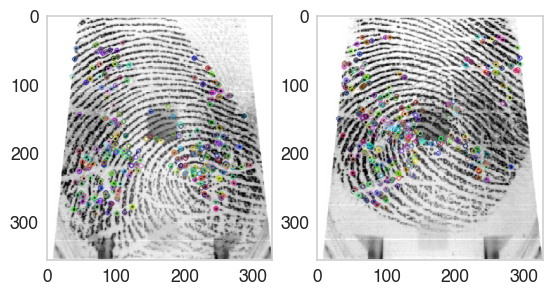

In [30]:
img1 = cv2.imread(path_train, 0)
img2 = cv2.imread(path_test, 0)

edges1, desc1 = edge_processing(img1, threshold=155) 
edges2, desc2 = edge_processing(img2, threshold=155)

plot_edges(img1, img2, edges1, edges2)

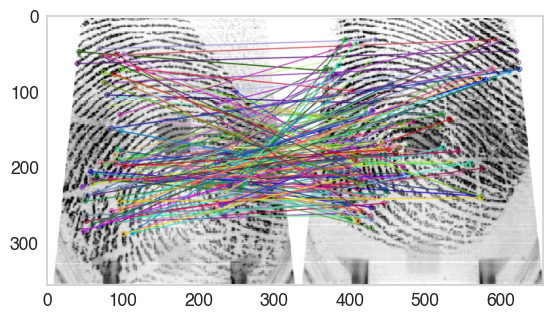

In [31]:
matches = match_edge_descriptors(desc1, desc2)

plot_matches(img1, img2, edges1, edges2, matches)

In [32]:
# ============================================
# Process All Images: Binarise + Adaptive Histogram Equalization
# ============================================
# Process all images from Project-Data and save to Project-Data-Processed-New

from skimage import exposure
import glob

def extract_number(filename):
    """从文件名中提取开头的数字部分用于排序"""
    basename = os.path.basename(filename)
    parts = basename.split('_')
    if parts:
        try:
            return int(parts[0])
        except ValueError:
            return 0
    return 0

def process_image_binarise_adapteq(img_path, output_path):
    """
    处理单张图像：binarise + adaptive histogram equalization
    保持原始图像大小，不进行resize
    
    Parameters:
        img_path: 输入图像路径
        output_path: 输出图像路径
    Returns:
        success: 是否成功处理
    """
    try:
        # 直接使用cv2.imread加载图像，保持原始大小（不经过load_image，避免可能的resize）
        raw_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if raw_img is None:
            print(f"  Warning: Unable to load image {img_path}")
            return False
        
        # 1. Binarise (保持原始大小)
        img_bin = binarise(raw_img)
        
        # 2. Adaptive histogram equalization (保持原始大小)
        img_adapteq = exposure.equalize_adapthist(img_bin, clip_limit=0.03)
        
        # 3. Convert to uint8 [0, 255] (equalize_adapthist returns [0, 1])
        img_processed = (img_adapteq * 255).astype(np.uint8)
        
        # 4. Save as .bmp (保持原始大小)
        cv2.imwrite(output_path, img_processed)
        return True
    except Exception as e:
        print(f"  Error processing {img_path}: {str(e)}")
        return False

# Configuration
SOURCE_DIR = '../Project-Data'
OUTPUT_DIR = '../Project-Data-Processed-New'

# Process each subdirectory
print("="*60)
print("Processing All Images: Binarise + Adaptive Histogram Equalization")
print("="*60)
print(f"Source directory: {SOURCE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print("Note: Images will be processed at their original size (no resize)")
print("="*60)

total_processed = 0
total_failed = 0

for subfolder in ['train', 'validate', 'test']:
    source_path = os.path.join(SOURCE_DIR, subfolder)
    output_path = os.path.join(OUTPUT_DIR, subfolder)
    
    if not os.path.exists(source_path):
        print(f"\nSkipping {subfolder} directory (does not exist)")
        continue
    
    # Create output directory
    os.makedirs(output_path, exist_ok=True)
    
    # Get all .bmp files
    image_files = glob.glob(os.path.join(source_path, '*.bmp'))
    
    # Sort by number (extract number from filename)
    image_files = sorted(image_files, key=extract_number)
    
    print(f"\nProcessing {subfolder} directory...")
    print(f"  Source directory: {source_path}")
    print(f"  Output directory: {output_path}")
    print(f"  Found {len(image_files)} image files")
    
    processed_count = 0
    failed_count = 0
    
    for img_file in image_files:
        filename = os.path.basename(img_file)
        output_file = os.path.join(output_path, filename)
        
        if process_image_binarise_adapteq(img_file, output_file):
            processed_count += 1
        else:
            failed_count += 1
        
        if processed_count % 100 == 0:
            print(f"  Processed: {processed_count}/{len(image_files)}")
    
    print(f"  ✓ Complete: Successfully processed {processed_count} images, failed {failed_count}")
    total_processed += processed_count
    total_failed += failed_count

print("\n" + "="*60)
print("Processing Complete!")
print(f"Total: Successfully processed {total_processed} images, failed {total_failed}")
print(f"Processed data saved to: {OUTPUT_DIR}")
print("="*60)


Processing All Images: Binarise + Adaptive Histogram Equalization
Source directory: ../Project-Data
Output directory: ../Project-Data-Processed-New
Note: Images will be processed at their original size (no resize)

Processing train directory...
  Source directory: ../Project-Data/train
  Output directory: ../Project-Data-Processed-New/train
  Found 1464 image files
  Processed: 100/1464
  Processed: 200/1464
  Processed: 300/1464
  Processed: 400/1464
  Processed: 500/1464
  Processed: 600/1464
  Processed: 700/1464
  Processed: 800/1464
  Processed: 900/1464
  Processed: 1000/1464
  Processed: 1100/1464
  Processed: 1200/1464
  Processed: 1300/1464
  Processed: 1400/1464
  ✓ Complete: Successfully processed 1464 images, failed 0

Processing validate directory...
  Source directory: ../Project-Data/validate
  Output directory: ../Project-Data-Processed-New/validate
  Found 500 image files
  Processed: 100/500
  Processed: 200/500
  Processed: 300/500
  Processed: 400/500
  Processed: 5

In [ ]:
img_bin = binarise(img)
 # 2. Adaptive histogram equalization (保持原始大小)
img_adapteq = exposure.equalize_adapthist(img_bin, clip_limit=0.03)
        
        # 3. Convert to uint8 [0, 255] (equalize_adapthist returns [0, 1])
img_processed = (img_adapteq * 255).astype(np.uint8)


display_image(np.hstack((img, img_bin, img_adapteq)))
print(f'Threshold OTSU: {threshold}')